# Model Comparison

_Jorge III Altamirano Astorga, Luz Aurora Hernández Martínez, Ita-Andehui Santiago Castillejos._

_Prof. Dr. Edgar Francisco Román-Rangel._

We trained our models using Vertex AI in order to have enough computational resources to load as much history as possible within our budget.

In [90]:
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
from IPython.display import display, Markdown, Math, clear_output, Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Taken from https://stackoverflow.com/a/39358722/7323086
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', size=font_size*1.05)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.show()

#df.dropna(inplace=True)
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Gráficas de Desempeño."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

# Comparison of Trained Models using Different Time Windows

## 1 Week History

In [140]:
def model_performance_df(models_path=""):
  models = []
  object_names = []
  objects = {}
  
  for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
    model_path = os.path.join(models_path, y)
    with io.open(model_path, 'rb') as file:
        object_name = re.sub(r"\.", "_", y)
        object_name = re.sub(r"_dill", "", object_name)
        objects[object_name] = dill.load(file)
        object_names.append(object_name)
  model_times = [o
                 for o in object_names 
                 if o.endswith("_time")]
  
  model_hists = [o
                 for o in object_names 
                 if o.endswith("_hist")]
  
  model_tsparams = [o
                 for o in object_names 
                 if o.endswith("_tsparams")]
  
  print(objects["scaler-iaq"])
  
  perf_table = pd.DataFrame({
    "Model": [re.sub("_time$", "", model_time) for model_time in model_times],
    "Time": [objects[model_time] for model_time in model_times],
    "Epochs": [len(objects[model_hist]["loss"]) for model_hist in model_hists],
    "Window Size Days": [objects[model_ts]["window_size_days"] for model_ts in model_tsparams],
    "Stride": [objects[model_ts]["stride"] for model_ts in model_tsparams],
    "Sampling Rate": [objects[model_ts]["sampling_rate"] for model_ts in model_tsparams],
    "Batch Size": [objects[model_ts]["batch_size"] for model_ts in model_tsparams],
    "MSE": [objects[model_hist]["val_loss"][-1] for model_hist in model_hists],
    "MAE": [objects[model_hist]["val_mae"][-1] for model_hist in model_hists],
  })
  
  ### Remove MinMaxScaler from MAE: ie IAQ scale.
  perf_table["MAE"] = (
    objects["scaler-iaq"].
    inverse_transform( ## do the inverse
      ## reshape info an array (n_rows, 1)
      perf_table["MAE"].to_numpy().reshape(1,-1)
    )
  ).reshape(-1) #reshape array back into (n_rows) shape
  
  perf_table.sort_values("MAE", inplace=True)
  perf_table.reset_index(drop=True, inplace=True)
  return perf_table

base_path = "data/vertex-models/output/"
perf_table = model_performance_df(base_path)
perf_table

MinMaxScaler()


/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Model,Time,Epochs,Window Size Days,Stride,Sampling Rate,Batch Size,MSE,MAE
0,model_best01a,658.977171,31,8,1,2,128,0.022389,65.391378
1,model_best03a,699.986566,31,8,1,2,128,0.022605,65.814023
2,model_best03b,500.358927,31,8,1,2,128,0.023344,66.997747
3,model_dnn01,184.883984,31,8,1,2,128,0.041922,87.206659


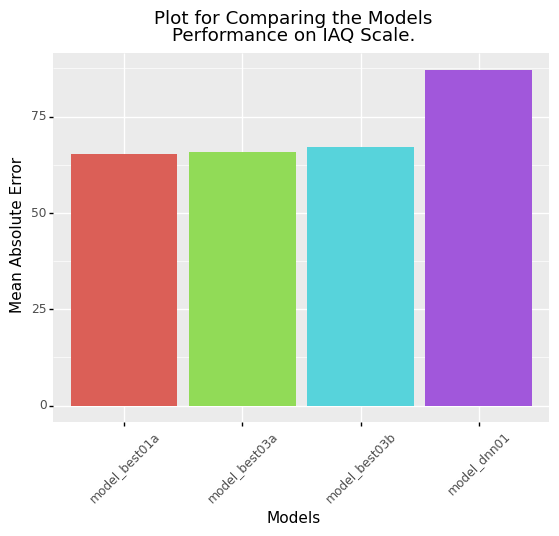

<ggplot: (8735050386285)>

In [141]:
Models_list = perf_table["Model"].tolist()
Models = pd.Categorical(perf_table["Model"], 
                         categories=Models_list)
perf_table["Modelo2"] = Models
(
  ggplot(perf_table.head(5), aes(x="Modelo2", y="MAE", fill="Modelo2")) +
  geom_bar(stat="identity") +
  #geom_bar(aes(y="mae"), stat="identity") +
  labs(y="Mean Absolute Error", x="Models", 
       title="Plot for Comparing the Models\nPerformance on IAQ Scale."
      ) +
  theme(legend_position="none", axis_text_x=element_text(rotation=45))
)

In [142]:
for i, model in enumerate(perf_table["Model"]):
  display(Markdown(f"{i+1}. Model \"{model}\""))
  display(Markdown(f"![{model}.png]({base_path+model}.png)"))

1. Model "model_best01a"

![model_best01a.png](data/vertex-models/output/model_best01a.png)

2. Model "model_best03a"

![model_best03a.png](data/vertex-models/output/model_best03a.png)

3. Model "model_best03b"

![model_best03b.png](data/vertex-models/output/model_best03b.png)

4. Model "model_dnn01"

![model_dnn01.png](data/vertex-models/output/model_dnn01.png)

## 2 Week History

In [136]:
def model_performance_df(models_path=""):
  models = []
  object_names = []
  objects = {}
  
  for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
    model_path = os.path.join(models_path, y)
    with io.open(model_path, 'rb') as file:
        object_name = re.sub(r"\.", "_", y)
        object_name = re.sub(r"_dill", "", object_name)
        objects[object_name] = dill.load(file)
        object_names.append(object_name)
  model_times = [o
                 for o in object_names 
                 if o.endswith("_time")]
  
  model_hists = [o
                 for o in object_names 
                 if o.endswith("_hist")]
  
  model_tsparams = [o
                 for o in object_names 
                 if o.endswith("_tsparams")]
  
  print(objects["scaler-iaq"])
  
  perf_table = pd.DataFrame({
    "Model": [re.sub("_time$", "", model_time) for model_time in model_times],
    "Time": [objects[model_time] for model_time in model_times],
    "Epochs": [len(objects[model_hist]["loss"]) for model_hist in model_hists],
    "Window Size Days": [objects[model_ts]["window_size_days"] for model_ts in model_tsparams],
    "Stride": [objects[model_ts]["stride"] for model_ts in model_tsparams],
    "Sampling Rate": [objects[model_ts]["sampling_rate"] for model_ts in model_tsparams],
    "Batch Size": [objects[model_ts]["batch_size"] for model_ts in model_tsparams],
    "MSE": [objects[model_hist]["val_loss"][-1] for model_hist in model_hists],
    "MAE": [objects[model_hist]["val_mae"][-1] for model_hist in model_hists],
  })
  
  ### Remove MinMaxScaler from MAE: ie IAQ scale.
  perf_table["MAE"] = (
    objects["scaler-iaq"].
    inverse_transform( ## do the inverse
      ## reshape info an array (n_rows, 1)
      perf_table["MAE"].to_numpy().reshape(1,-1)
    )
  ).reshape(-1) #reshape array back into (n_rows) shape
  
  perf_table.sort_values("MAE", inplace=True)
  perf_table.reset_index(drop=True, inplace=True)
  return perf_table

base_path = "data/vertex-models/output-2w/"
perf_table = model_performance_df(base_path)
perf_table

MinMaxScaler()


/opt/intel/oneapi/intelpython/latest/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


,Model,Time,Epochs,Window Size Days,Stride,Sampling Rate,Batch Size,MSE,MAE
0,model_best03b,629.414618,28,15,1,2,128,0.019970,57.656134
1,model_best01a,865.906092,28,15,1,2,128,0.019819,58.824076
2,model_best03a,864.207575,28,15,1,2,128,0.020162,60.483345
3,model_dnn01,223.165007,28,15,1,2,128,0.020358,60.661538


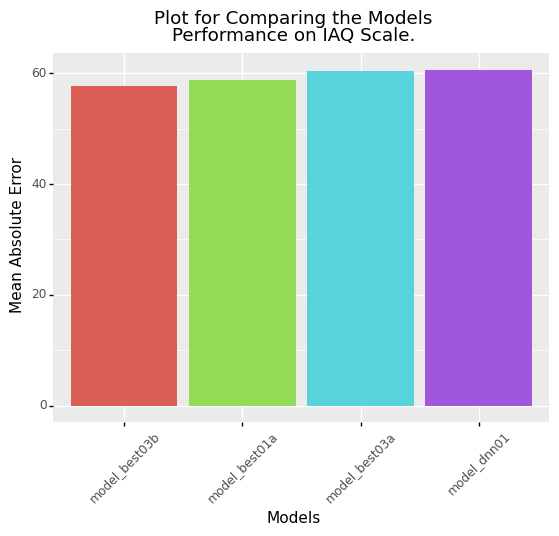

<ggplot: (8735050229137)>

In [135]:
Models_list = perf_table["Model"].tolist()
Models = pd.Categorical(perf_table["Model"], 
                         categories=Models_list)
perf_table["Modelo2"] = Models
(
  ggplot(perf_table.head(5), aes(x="Modelo2", y="MAE", fill="Modelo2")) +
  geom_bar(stat="identity") +
  #geom_bar(aes(y="mae"), stat="identity") +
  labs(y="Mean Absolute Error", x="Models", 
       title="Plot for Comparing the Models\nPerformance on IAQ Scale."
      ) +
  theme(legend_position="none", axis_text_x=element_text(rotation=45))
)

In [138]:
for i, model in enumerate(perf_table["Model"]):
  display(Markdown(f"{i+1}. Model \"{model}\""))
  display(Markdown(f"![{model}.png]({base_path+model}.png)"))

1. Model "model_best03b"

![model_best03b.png](data/vertex-models/output-2w/model_best03b.png)

2. Model "model_best01a"

![model_best01a.png](data/vertex-models/output-2w/model_best01a.png)

3. Model "model_best03a"

![model_best03a.png](data/vertex-models/output-2w/model_best03a.png)

4. Model "model_dnn01"

![model_dnn01.png](data/vertex-models/output-2w/model_dnn01.png)

# Referencias

* Keras contributors et al. [Keras / Code examples / Timeseries / Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). 2021.

* Tensorflow Contributors. [Tensorflow: Tutorial on Time series forecastingTime series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_serieshttps://www.tensorflow.org/tutorials/structured_data/time_series). 2021.

* Román-Rangel, Francisco. Notas y Código del Curso de Aprendizaje Profundo. 2021.

* González-Pérez, Felipe. [Notas de aprendizaje de máquina (2020)](https://lucid-torvalds-517e78.netlify.app/)
